# 2024-1 DSL 정규세션 과제

## CNN Assignment

- 작성자 : 윤형진
- 참고자료 : PyTorch Document
- 과제 제출 기한 : 02.18

---
- 이름 :     
- 기수 :     



## 해당 과제에는 6개의 섹션과 7개의 문제가 있습니다! 누락없이 제출 부탁드립니다 :)

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [ ]:
# colab 환경에서 학습을 진행하실 분들은 구글드라이브를 연동해주세요
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from PIL import Image

"""
MetaData.csv를 나누어 만든 train, val, test 데이터프레임에 담긴 이미지와 레이블을 반환해주는 CustomImageDataset을 만들어주세요
참고자료 : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
"""

class CustomImageDataset(Dataset):

    def __init__(self, dataset_direc:str, df:pd.DataFrame, transform = None) -> None:

        # 3000개의 이미지를 담고있는 DataSet 디렉토리의 경로입니다.
        self.dataset_direc= dataset_direc

        self.df = df.reset_index(drop=True)

        self.to_tensor = ToTensor() # 파이토치에서는 모든 인풋을 torch.Tensor()로 바꿔줘야합니다.

        self.transform = transform

    # __init__() 함수에서 받은 데이터프레임에 포함된 전체 데이터포인트의 수를 반환하도록 해주세요
    def __len__(self) -> int :
        return len(self.df)



    def __getitem__(self, idx:int):

        final_directory = os.path.join(self.dataset_direc, self.df['StrLabel'].iloc[idx], self.df['FileName'].iloc[idx])

        image = Image.open(final_directory)

        label = self.df['Label'].iloc[idx]

        image = self.to_tensor(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# 이번 과제의 일부였던 CustomDataset.py, Model.py를 로드해주세요
#from CustomDataset import CustomImageDataset
#from Model import ResNet50

import pandas as pd
import numpy as np

import yaml
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
class ResBottleNeck(nn.Module):
    expansion = 4  # Expansion value for bottleneck

    def __init__(self, in_dim, out_dim, stride=1) -> None:
        super(ResBottleNeck, self).__init__()
        dim = out_dim * ResBottleNeck.expansion
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=in_dim, out_channels=out_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_dim, out_channels=out_dim, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_dim, out_channels=dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(dim)
        )

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or in_dim != dim:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_dim, out_channels=dim, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(dim)
            )

    def forward(self, x):
        residual = x
        out = self.bottleneck(x)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet50(nn.Module):
    def __init__(self, num_classes=1) -> None:
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, blocks=3)
        self.layer2 = self._make_layer(256, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(512, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(1024, 512, blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def _make_layer(self, in_dim, out_dim, blocks, stride=1):
        layers = []
        layers.append(ResBottleNeck(in_dim, out_dim, stride))
        for _ in range(1, blocks):
            layers.append(ResBottleNeck(out_dim * ResBottleNeck.expansion, out_dim))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
# config.yaml의 위치를 지정해주세요
config_path = "/content/drive/MyDrive/학회/[240206]_CNN_YOURNAME/scripts/config.yaml"

In [ ]:
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print(config)

{'HyperParameters': {'Epoch': 40, 'BatchSize': 80, 'LearningRate': None}, 'Direc': {'DatasetDirec': '<여러분의 디렉토리>/DataSet', 'MetaDataDirec': '<여러분의 데릭토리>/scripts/MetaData.csv', 'WeightDirec': '<여러분의 디렉토리>/BestModel'}}


# 1. 하이퍼파라미터 및 기타 주요 변수 설정

config.yaml에 지정해줬던 디렉토리, 모델 하이퍼파라미터들을 가져옵시다

In [ ]:

dataset_direc = "/content/drive/MyDrive/[240206]_CNN_YOURNAME/DataSet"

meta_direc = "/content/drive/MyDrive/[240206]_CNN_YOURNAME/scripts/MetaData.csv"
weight_direc  = "/content/drive/MyDrive/[240206]_CNN_YOURNAME/BestModel"


epoch, batch_size, lr = 30, 80, 0.001



In [ ]:
import wandb # wandb.ai으로의 실시간 연동을 위한 라이브러리 임포트
from signal import signal, SIGPIPE, SIG_DFL
#Ignore SIG_PIPE and don't throw exceptions on it... (http://docs.python.org/library/signal.html)
signal(SIGPIPE,SIG_DFL)

# wandb login
wandb.init(
    project="DSL_ResNet3", entity="woni5806",
    name="Brain Tumor3",
    config={
        "model_name": "Brain Tumor final",
        "epochs": epoch,
        "batch_size": batch_size,
        "lr": lr
    })

config = wandb.config
#42f2dd32632680997d4be527bcfc8a91bb7265f0
#42f2dd32632680997d4be527bcfc8a91bb7265f0

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# 가속을 위해 device로 GPU로 설정해줍니다
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. train, val, test DataLoader 초기화

### 문제 1.

모델의 학습을 train, validation, test로 나눠서 진행하는 이유는 무엇인가요?
- (힌트 : 굳이 validation을 끼워넣는 이유는 무엇인가요?)
- Train set은 모델을 학습시키고, Validation set은 하이퍼파라미터 튜닝을 하며, Test set은 모델의 최종 성능을 평가한다. train set을 분리시키지 않으면 오버피팅 문제가 발생하고, validation set은 성능을 검증하는 데에 쓰인다.
### 문제 2.

모델의 generalization을 높여주기 위해 Augmentation을 사용할 수 있다고 했습니다.

PyTorch 구현상으로는 train, validation, test 모든 단계에 Augmention를 구현할 수 있습니다만, 실제로는 특정 단계에서만 Augmention를 수행하게 됩니다. 어느 단계에서 RandAugment가 적용되어야하는지와, 그 이유에 대해서 설명해주세요.

- 훈련 데이터에 대해서만 적용한다. 작업 자체가 학습시킬 데이터셋을 증강, 다양성을 향상시켜 성능을 높이는 데에 목적이 있기 때문에 검증과 평가에는 사용하지 않는다.

### 문제 3.
CustomImageDataset과 DataLoader 클래스의 차이점에 대해서 설명해주세요.
- Custom은 하나의 데이터를 return 하나 DataLoader는 데이터를 미니 배치로 나누어 로드한다.

In [ ]:
# MetaData.csv를 로드해주고, train, val, test로 나눠줍니다
meta_data = pd.read_csv(meta_direc)

# train : val : test = 6 : 2 : 2
train, val = train_test_split(meta_data, train_size=0.6, random_state=777)
val_test, test = train_test_split(meta_data, train_size=0.5, random_state=777)

# Model generalization을 위해 RandomAugmentation에 어떤 변형을 가할 지 transforms.Compose([])로 묶어놓읍시다
train_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

])

# CustomDataset.py에서 가져온 CustomImageDataset 클래스에 train, val, test 데이터프레임을 패스하여 데이터셋을 만들어주세요
train_dataset = CustomImageDataset(dataset_direc=dataset_direc, df=meta_data , transform = train_transforms)
val_dataset   = CustomImageDataset(dataset_direc=dataset_direc, df=meta_data , transform = train_transforms)
test_dataset  = CustomImageDataset(dataset_direc=dataset_direc, df=meta_data , transform = None)


train_loader = DataLoader(train_dataset , batch_size = 64 ,shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size = 64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size = 64, shuffle=True)

# 3. 모델 초기화, 손실함수 및 optimizer 지정

### 문제 4.

주어진 과제는 Binary Classification 태스크입니다.

이중 분류를 위해서는 손실함수로 Binary Cross Entropy를 사용한다고 세션에서 배웠습니다.

PyTorch에는 Binary Cross Entropy를 학습에 사용할 수 있는 2가지 방법이 있는데요, 'nn.BCELoss'와 'nn.BCEWithLogitsLoss'입니다.

이 둘은 같아 보이지만 구현상에서 명백한 차이점이 있습니다.

이 둘의 차이점에 대해서 서술해주세요.


-BCELoss에는 sigmoid가 포함되어있지 않다.  nn.BCEWithLogitsLoss는 BCELoss 내부에 sigmoid가 포함된 버전이다.

In [ ]:
# model을 선언하고 GPU에 올려줍니다
model = ResNet50()
model.to(device)

ResNet50(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (bottleneck): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inp

In [ ]:
# 손실함수를 정의해주세요
criterion =  nn.BCEWithLogitsLoss()
# optimizer를 정의해주세요
optimizer = optim.Adam(model.parameters(), lr=lr)

# 4. Training 시작

학습을 위한 모든 준비가 끝났습니다! ㄱㅂㅈㄱ

### 문제 5.
학습이 끝난 이후 val_loss, train_loss 변화 추이 그래프와 val_acc, train_acc 변화 추이 그래프를 첨부해주세요.
(wandb 대시보드에서 캡쳐하셔도 됩니다)

In [ ]:
# Best Validation Loss를 양의 무한대로 초기화
best_loss = float("inf")


# Training, Validation 시작

for curr_epoch in range(epoch+1): # iterate over all EPOCHS
  train_loss = 0
  correct_train = 0

  for img, label in (train_loader): # iterate over all BATCHES

    # GPU에 올라가는 건 모델 뿐 아니라 데이터도 같이 올라가야합니다!
    img, label = img.to(device), label.to(device)



    # Forward Propagation
    pred = model(img)
    label = label.view(-1,1).float()

    # 손실함수 계산
    loss = criterion(pred, label) # 구현상의 차이로 label 텐서에 조작을 가해 모양을 맞춰줘야하는 경우가 생길 수 있습니다 ( 힌트 : tensor.view() )

    # 누적된 기울기 초기화 및 역전파
    optimizer.zero_grad()
    loss.backward()

    # 파라미터 업데이트
    optimizer.step()

    # 해당 Batch에서의 loss를 train_loss 변수에 누적
    train_loss += loss.item()

    # Accuracy 계산
    pred_class = (torch.sigmoid(pred) > 0.5).float()
    correct_train += (pred_class == label).float().sum()

  # 모든 Batch를 순회한 이후 최종적인 train_loss, train_acc를 계산해줍니다
  train_loss = train_loss/len(train_loader.dataset)
  train_acc = correct_train /len(train_loader.dataset)

  # Validation 시작
  model.eval()

  with torch.no_grad():  # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
    val_loss = 0
    correct_val = 0

    for img, label in (val_loader): # iterate over all BATCHES
        # GPU에 올라가는 건 모델 뿐 아니라 데이터도 같이 올라가야합니다!
      img, label = img.to(device), label.to(device)
      label = label.view(-1,1).float()

        # Forward Propagation
      pred = model(img)

        # 손실함수 계산
      loss = criterion(pred, label)

      val_loss += loss.item()

      # 모든 Batch를 순회한 이후 최종적인 val_loss, val_acc를 계산해줍니다
      pred_class = (torch.sigmoid(pred) > 0.5).float()
      correct_val += (pred_class == label).float().sum()

    val_loss /= len(val_loader)
    val_acc = correct_val / len(val_loader)

  # wandb.ai에 보낼 log 데이터를 작성해줍니다.
  metrics = {
    "epoch": epoch,
    "train_loss": train_loss,
    "val_loss" : val_loss,
    "train_acc": train_acc.item(),
    "val_acc" : val_acc.item(),
    "learning_rate": lr
    }

  # 아래 코드를 통해 실시간으로 학습현황을 확인할 수 있도록 log 데이터를 전송해줍니다
  wandb.log(metrics)

  # 모델을 다시 학습모드로 설정합니다
  model.train()

  # 가장 작은 validation loss를 가졌을 때의 모델 파라미터를 저장해줍니다.
  if val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), os.path.join(weight_direc, "best_model(aug).pt")) # .pt 확장자로 저장해주도록합니다

wandb.finish()


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# 5. Test

학습이 모두 끝났다면, 가장 낮은 validation loss를 기록한 모델의 파라미터를 불러오도록합시다.

이후에는 confusion matrix, accuracy 등을 측정하여 모델이 얼마나 잘 학습되었는지 평가하도록 하겠습니다.

### 문제6.

accuracy 95% 이상이 되도록 학습률 등을 조절해주세요.

In [ ]:


trained_model = ResNet50() # 우선 ResNet50 모델 하나를 초기화 해줍니다
trained_model.load_state_dict(torch.load(os.path.join(weight_direc, "best_model(aug).pt"))) # 아까 저장해둔 weight를 로드해줍니다
trained_model.eval() # 모델을 evaluation 모드로 설정합니다
trained_model.to(device)

ResNet50(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (bottleneck): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inp

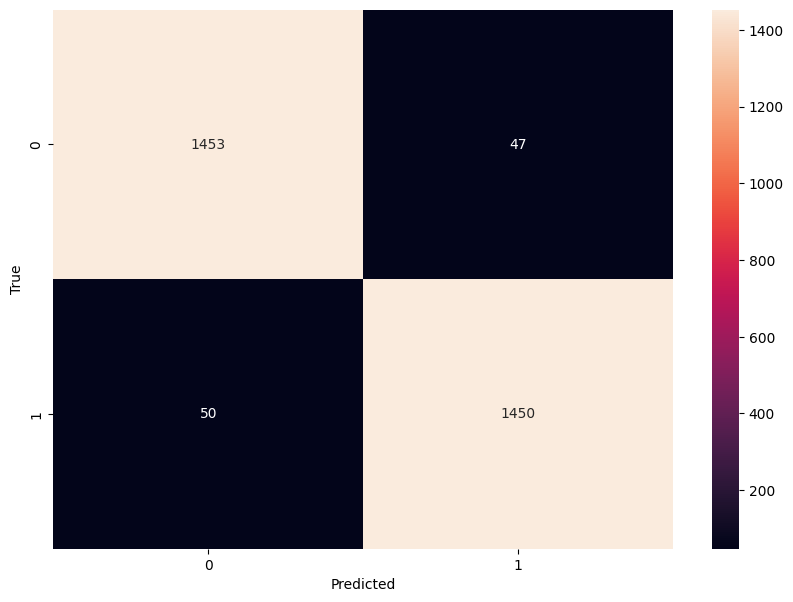

Accuracy: 96.77%


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

all_labels = []
all_predictions = []

for batch_no, (image, label) in enumerate(test_loader):
  image, label = image.to(device), label.to(device)

  with torch.no_grad(): # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
    pred = model(image) # 순전파

    probabilities = torch.sigmoid(pred) # 시그모이드 함수를 이용해 확률을 계산합니다
    predicted = (probabilities > 0.5).float()  # 확률을 label로 바꿔줍니다

    all_labels.extend(label.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

# Confusion matrix를 그려줍니다
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy도 출력해봅시다
accuracy = accuracy_score(all_labels, all_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
print(len(all_labels))
print(len(all_predictions))

3000
2632


# 6. Augmentation vs No Augmentation

### 문제 7.

전달받으신 파일들 중, Run_NoAugment.ipynb라는 파일이 있을 겁니다.

지금 보고 계신 노트북과 똑같이 학습을 시키시되, 이번에는 학습 시 data augmentation을 적용시키지 않고 진행하십시오.

이후 augmentation을 적용시키지 않은 모델의 train loss와 val loss의 차트를 아래에 붙여놓으시고,

augmentation을 적용한 모델의 학습 양상과 어떤 점이 다른 지와 그 이유도 함께 설명해주세요.

No augmentation

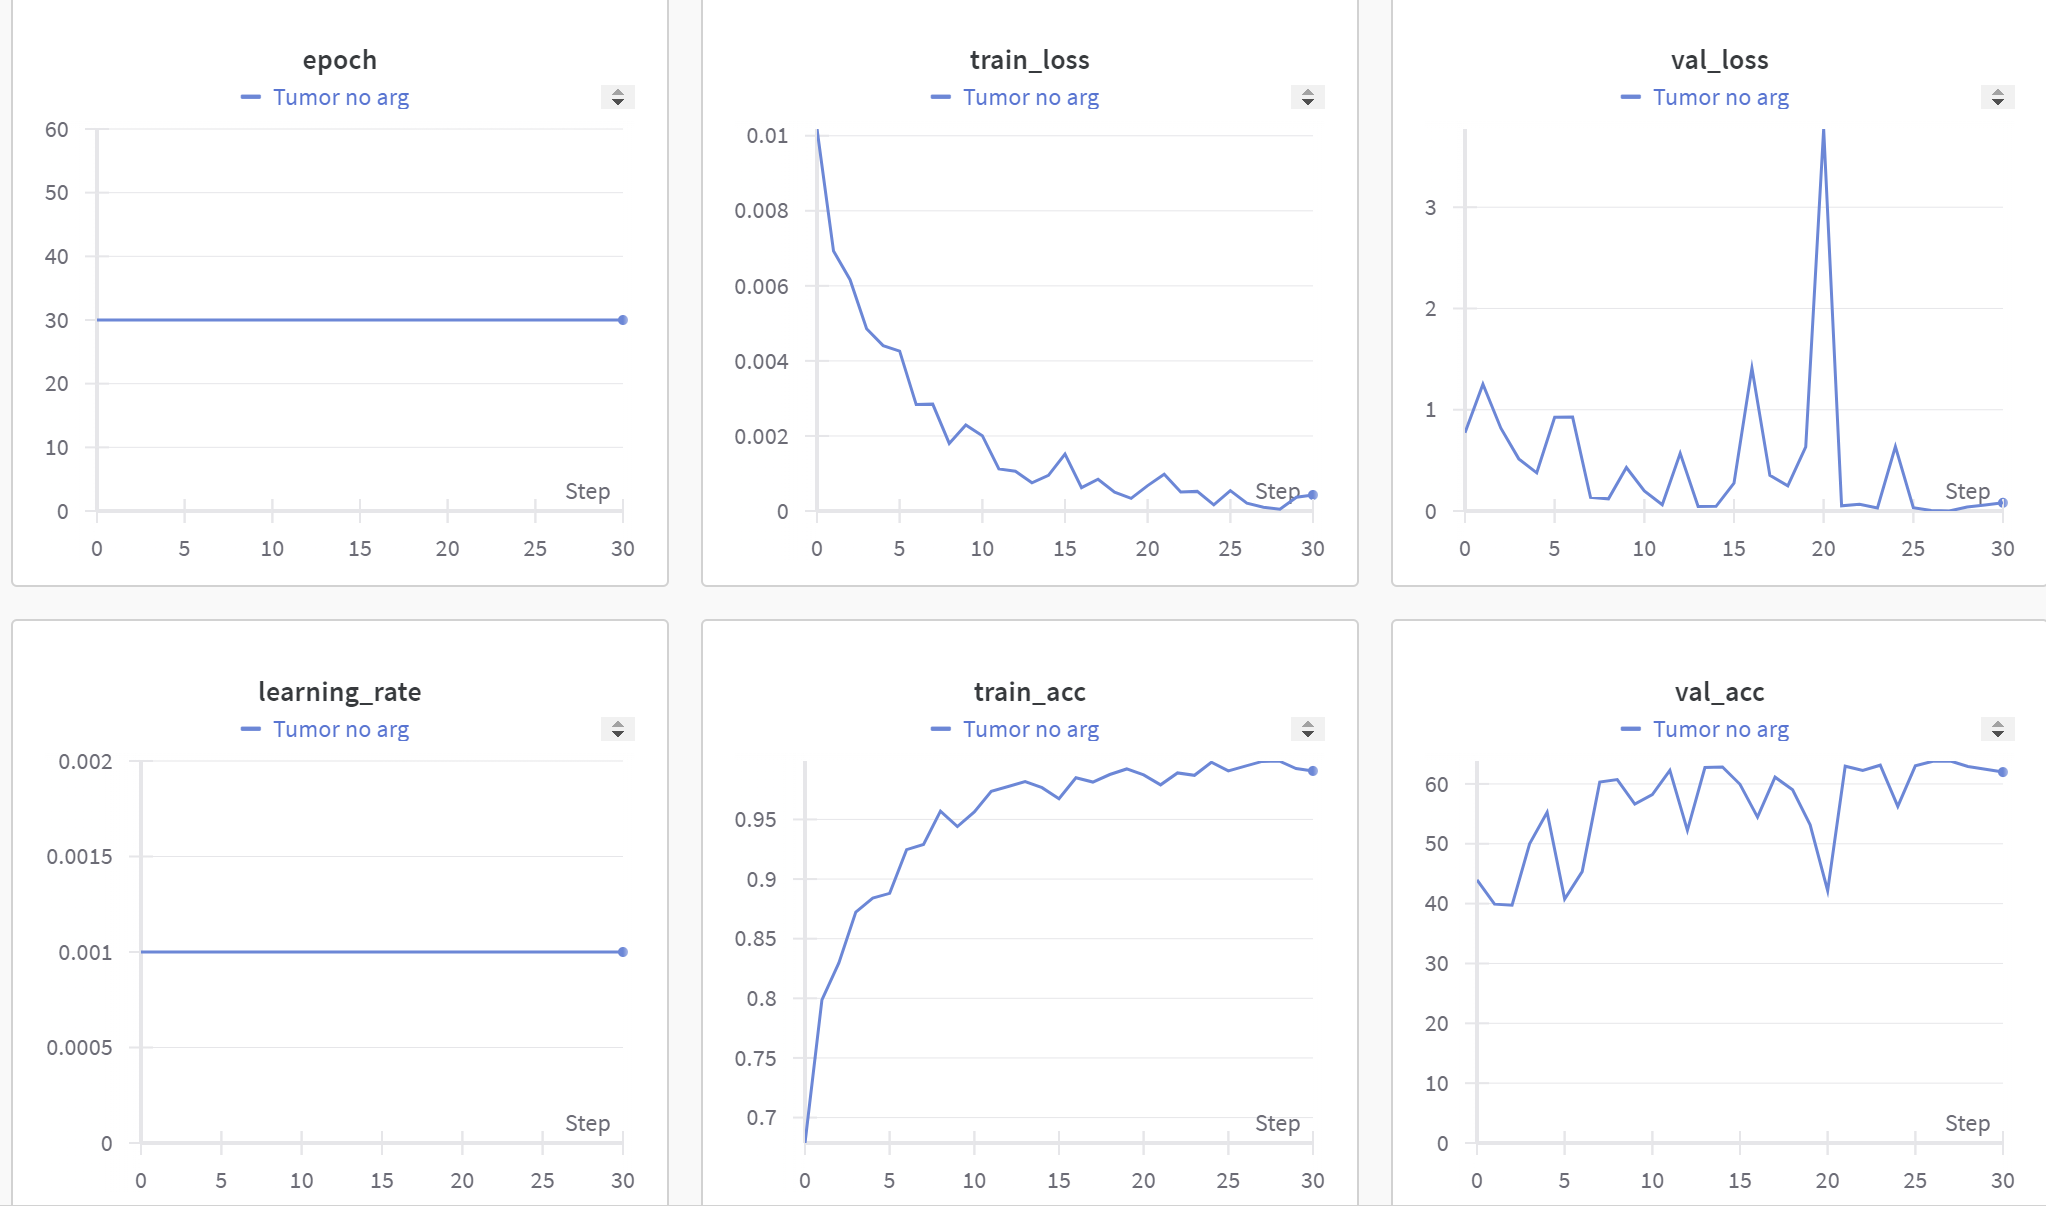

Augmentation

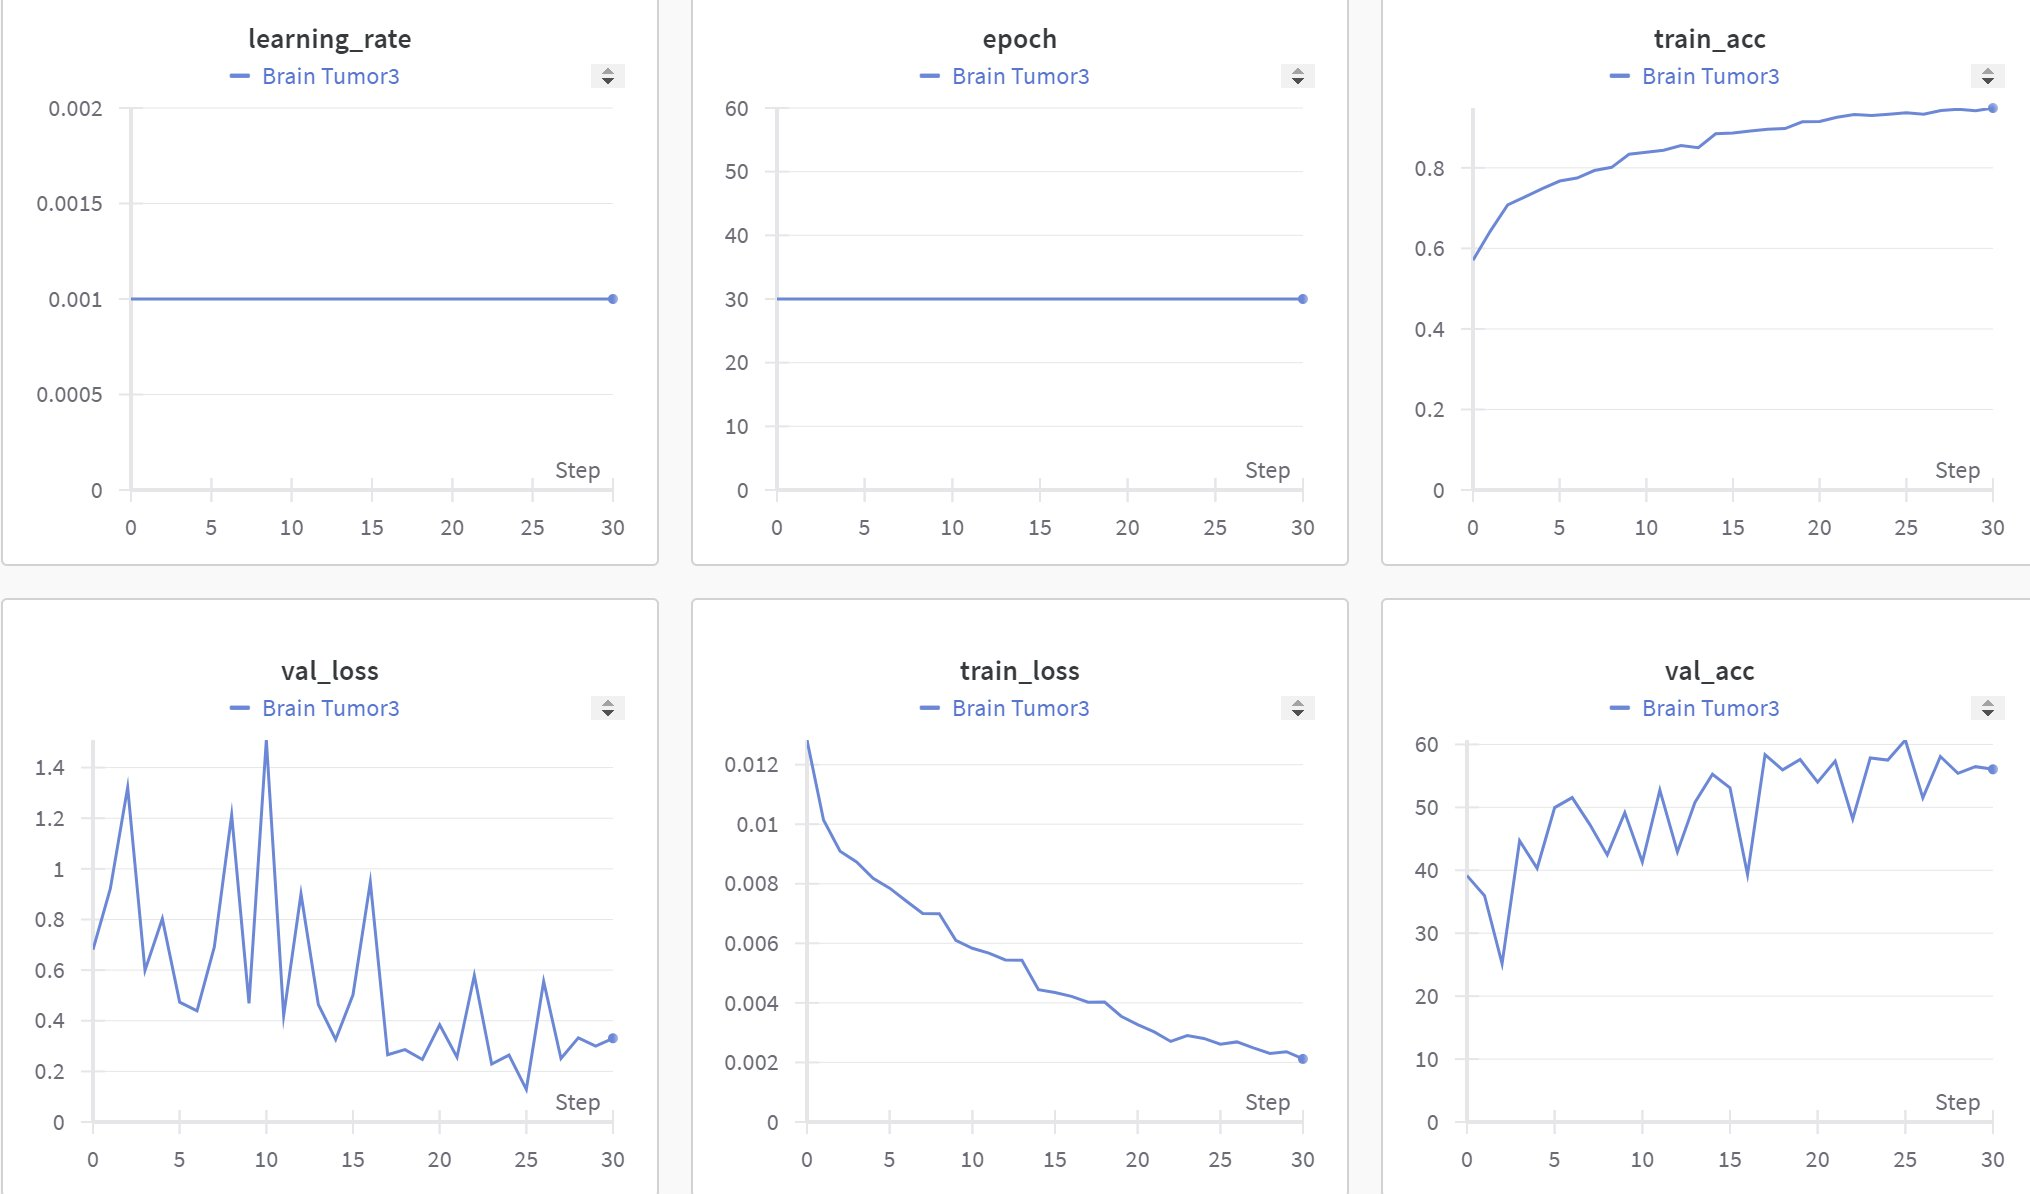

augmentation을 적용하지 않은 쪽이 적용한 쪽보다 val, train loss가 낮게 나왔다. accuracy도 0.99에 육박하는 것을 보아 과적합을 의심해볼 수 있다.
